<a href="https://colab.research.google.com/github/desstaw/DataPrivacy_SimulatedAnnealing/blob/main/Main_Hierarchical_Generalization_Stroke_MIMICIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import random
import math

# Load data
url = "/content/drive/MyDrive/Colab Notebooks/MIMIC III/avg_patient_cohort.csv"
df = pd.read_csv(url)

In [ ]:
print (list(df))

['charttime', 'icustay_id', 'hadm_id', 'subject_id', 'intime', 'outtime', 'los_hours', 'dbsource', 'icustays_count', 'age', 'patientweight', 'gender', 'ethnicity', 'admission_type', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'diagnosis_text', 'dob', 'dod', 'death_in_hosp', 'death_3_days', 'death_30_days', 'death_180_days', 'death_365_days', 'preiculos', 'mechvent', 'electivesurgery', 'stroke_type', 'infarct_type', 'hypertension_flag', 'diabetes_flag', 'cancer_flag', 'obesity_flag', 'drug_abuse_flag', 'sepsis_flag', 'icd9_code', 'all_icd9_codes', 'Anion Gap', 'Arterial Blood Pressure diastolic', 'Arterial Blood Pressure mean', 'Arterial Blood Pressure systolic', 'Bicarbonate', 'Calcium Total', 'Chloride (whole blood)', 'Creatinine', 'day_on_icu', 'gauges_total', 'gcs', 'Glucose (whole blood)', 'Heart Rate', 'Hemoglobin', 'INR', 'O2 saturation pulseoxymetry', 'oasis', 'oasis_prob', 'Packed Red Blood Cells', 'Platelet Count', 'Potassium (whole blood)', 'P

##Preprocessing Steps:

### Select the relevant features for our use case

In [ ]:
df = df[['age', 'patientweight', 'gender', 'ethnicity', 'marital_status', 'infarct_type', 'hypertension_flag', 'diabetes_flag', 'cancer_flag', 'obesity_flag', 'drug_abuse_flag',
             'Anion Gap', 'Arterial Blood Pressure diastolic', 'Arterial Blood Pressure systolic', 'Bicarbonate', 'Calcium Total', 'Chloride (whole blood)', 'Creatinine', 'all_icd9_codes',
             'gauges_total', 'gcs', 'Glucose (whole blood)', 'Heart Rate', 'Hemoglobin', 'INR', 'O2 saturation pulseoxymetry', 'oasis', 'Packed Red Blood Cells', 'los_hours',
             'Platelet Count', 'Potassium (whole blood)', 'Respiratory Rate', 'Sodium (whole blood)', 'White Blood Cells', 'stroke_type', 'icustays_count', 'admission_type', 'death_in_hosp', 'religion', 'death_365_days']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                2655 non-null   int64  
 1   patientweight                      1309 non-null   float64
 2   gender                             2655 non-null   int64  
 3   ethnicity                          2655 non-null   int64  
 4   marital_status                     2442 non-null   float64
 5   infarct_type                       2655 non-null   object 
 6   hypertension_flag                  2655 non-null   int64  
 7   diabetes_flag                      2655 non-null   int64  
 8   cancer_flag                        2655 non-null   int64  
 9   obesity_flag                       2655 non-null   int64  
 10  drug_abuse_flag                    2655 non-null   int64  
 11  Anion Gap                          2499 non-null   float

### Rename the columns and convert them all to lower case values

In [ ]:
df.rename(columns={'patientweight': 'weight',
                   'Anion Gap': 'anion_gap',
                   'Arterial Blood Pressure diastolic': 'ABP_diastolic',
                   'Arterial Blood Pressure systolic': 'ABP_systolic',
                   'Calcium Total': 'calcium',
                   'Chloride (whole blood)': 'chloride',
                   'Glucose (whole blood)': 'glucose',
                   'Heart Rate': 'heart_rate',
                   'O2 saturation pulseoxymetry': 'O2_saturation',
                   'Packed Red Blood Cells': 'packed_rbc',
                   'Platelet Count': 'platelet_count',
                   'Potassium (whole blood)': 'potassium',
                   'Respiratory Rate': 'repiratory_rate',
                   'Sodium (whole blood)': 'sodium',
                   'White Blood Cells': 'wbc'}, inplace=True)


In [ ]:
df.columns= df.columns.str.lower()
print (list(df))

['age', 'weight', 'gender', 'ethnicity', 'marital_status', 'infarct_type', 'hypertension_flag', 'diabetes_flag', 'cancer_flag', 'obesity_flag', 'drug_abuse_flag', 'anion_gap', 'abp_diastolic', 'abp_systolic', 'bicarbonate', 'calcium', 'chloride', 'creatinine', 'all_icd9_codes', 'gauges_total', 'gcs', 'glucose', 'heart_rate', 'hemoglobin', 'inr', 'o2_saturation', 'oasis', 'packed_rbc', 'los_hours', 'platelet_count', 'potassium', 'repiratory_rate', 'sodium', 'wbc', 'stroke_type', 'icustays_count', 'admission_type', 'death_in_hosp', 'religion', 'death_365_days']


### Take a look at the distribution of values in categorical features and adjust the generalizations accordingly as generalization sets need to have relatively large number of records to be able to anonymize with K-anonymity

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2655 non-null   int64  
 1   weight             1309 non-null   float64
 2   gender             2655 non-null   int64  
 3   ethnicity          2655 non-null   int64  
 4   marital_status     2442 non-null   float64
 5   infarct_type       2655 non-null   object 
 6   hypertension_flag  2655 non-null   int64  
 7   diabetes_flag      2655 non-null   int64  
 8   cancer_flag        2655 non-null   int64  
 9   obesity_flag       2655 non-null   int64  
 10  drug_abuse_flag    2655 non-null   int64  
 11  anion_gap          2499 non-null   float64
 12  abp_diastolic      2072 non-null   float64
 13  abp_systolic       2073 non-null   float64
 14  bicarbonate        2500 non-null   float64
 15  calcium            1087 non-null   float64
 16  chloride           2570 

In [ ]:
df.columns

Index(['age', 'weight', 'gender', 'ethnicity', 'marital_status',
       'infarct_type', 'hypertension_flag', 'diabetes_flag', 'cancer_flag',
       'obesity_flag', 'drug_abuse_flag', 'anion_gap', 'abp_diastolic',
       'abp_systolic', 'bicarbonate', 'calcium', 'chloride', 'creatinine',
       'all_icd9_codes', 'gauges_total', 'gcs', 'glucose', 'heart_rate',
       'hemoglobin', 'inr', 'o2_saturation', 'oasis', 'packed_rbc',
       'los_hours', 'platelet_count', 'potassium', 'repiratory_rate', 'sodium',
       'wbc', 'stroke_type', 'icustays_count', 'admission_type',
       'death_in_hosp', 'religion', 'death_365_days'],
      dtype='object')

In [ ]:
categorical_columns = ['gender', 'ethnicity', 'marital_status', 'infarct_type', 'hypertension_flag', 'diabetes_flag',
                       'cancer_flag', 'obesity_flag', 'drug_abuse_flag', 'stroke_type', 'icustays_count', 'admission_type', 'los_hours']


for column in categorical_columns:
    unique_values = df[column].unique()
    frequencies = df[column].value_counts()
    print(f"Unique values in {column}: {unique_values}")
    print(f"Frequencies:\n{frequencies}\n")

Unique values in gender: [0 1]
Frequencies:
0    1353
1    1302
Name: gender, dtype: int64

Unique values in ethnicity: [1 0 4 5 3 2]
Frequencies:
1    1846
0     279
4     252
3     112
5      88
2      78
Name: ethnicity, dtype: int64

Unique values in marital_status: [nan -1.  1.  0.]
Frequencies:
 1.0    1279
-1.0    1141
 0.0      22
Name: marital_status, dtype: int64

Unique values in infarct_type: ['no_infarct' 'NSTEMI' 'STEMI']
Frequencies:
no_infarct    2445
NSTEMI         144
STEMI           66
Name: infarct_type, dtype: int64

Unique values in hypertension_flag: [1 0]
Frequencies:
1    1517
0    1138
Name: hypertension_flag, dtype: int64

Unique values in diabetes_flag: [0 1]
Frequencies:
0    2023
1     632
Name: diabetes_flag, dtype: int64

Unique values in cancer_flag: [0 1]
Frequencies:
0    2247
1     408
Name: cancer_flag, dtype: int64

Unique values in obesity_flag: [0 1]
Frequencies:
0    2570
1      85
Name: obesity_flag, dtype: int64

Unique values in drug_abuse_fl

### Also take a look at the distribution of the numerical column (age) to spot outliers:

In [ ]:
'''
age_values = df['age']

plt.figure(figsize=(10, 6))
plt.hist(age_values, bins=20, color='blue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age Values')
plt.show()
'''

"\nage_values = df['age']\n\nplt.figure(figsize=(10, 6))\nplt.hist(age_values, bins=20, color='blue', edgecolor='black')\nplt.xlabel('Age')\nplt.ylabel('Frequency')\nplt.title('Distribution of Age Values')\nplt.show()\n"

In [ ]:
'''
age_sorted = df['age'].sort_values(ascending=True)
first_20_entries = age_sorted.head(30)
print(first_20_entries)
'''

"\nage_sorted = df['age'].sort_values(ascending=True)\nfirst_20_entries = age_sorted.head(30)\nprint(first_20_entries)\n"

### Generalizing Age

Divisive clustering with equal intervals where each level has 2^l nodes where l corresponds to level. Terminate the clustering process if one of the nodes at a specific level has number of records less than k. K here is the k-anonymity parameter value.  

In [ ]:
from collections import deque
df['age'] = df['age'].astype(float)
class TreeNode:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.children = []

def build_tree(data, level, node):
    if level == 0 or len(data) < 10:
        return

    step = (node.end - node.start) / 2
    left_child = TreeNode(node.start, node.start + step)
    right_child = TreeNode(node.start + step, node.end)

    node.children.append(left_child)
    node.children.append(right_child)

    left_data = data[(data >= left_child.start) & (data <= left_child.end)]
    right_data = data[(data > left_child.end) & (data <= right_child.end)]

    build_tree(left_data, level - 1, left_child)
    build_tree(right_data, level - 1, right_child)

def print_tree(tree):
    queue = deque([(tree, 0)])  # Store nodes and their levels in a queue

    while queue:
        level_nodes = []  # Store nodes at the current level
        level = queue[0][1]  # Get the level of the first node in the queue

        # Process nodes at the current level
        while queue and queue[0][1] == level:
            node, _ = queue.popleft()
            level_nodes.append(node)

        # Print level name and clusters with intervals
        print(f"Level {level}:")
        for node in level_nodes:
            start = int(node.start)
            end = int(node.end)
            print(f"  Cluster {level_nodes.index(node)}: ({start}, {end}]")

        # Add child nodes to the queue for the next level
        for node in level_nodes:
            queue.extend([(child, level + 1) for child in node.children])

        print()  # Add a line break after each level


age_column = df['age']
min_age = age_column.min()
max_age = age_column.max()

# Build the tree with 5 levels
#original
root = TreeNode(min_age, max_age)
#adjusted
#root = TreeNode(min_age, max_age + 1)
build_tree(age_column, 5, root)


print_tree(root)


Level 0:
  Cluster 0: (18, 91]

Level 1:
  Cluster 0: (18, 54]
  Cluster 1: (54, 91]

Level 2:
  Cluster 0: (18, 36]
  Cluster 1: (36, 54]
  Cluster 2: (54, 72]
  Cluster 3: (72, 91]

Level 3:
  Cluster 0: (18, 27]
  Cluster 1: (27, 36]
  Cluster 2: (36, 45]
  Cluster 3: (45, 54]
  Cluster 4: (54, 63]
  Cluster 5: (63, 72]
  Cluster 6: (72, 81]
  Cluster 7: (81, 91]

Level 4:
  Cluster 0: (18, 22]
  Cluster 1: (22, 27]
  Cluster 2: (27, 31]
  Cluster 3: (31, 36]
  Cluster 4: (36, 40]
  Cluster 5: (40, 45]
  Cluster 6: (45, 49]
  Cluster 7: (49, 54]
  Cluster 8: (54, 59]
  Cluster 9: (59, 63]
  Cluster 10: (63, 68]
  Cluster 11: (68, 72]
  Cluster 12: (72, 77]
  Cluster 13: (77, 81]
  Cluster 14: (81, 86]
  Cluster 15: (86, 91]

Level 5:
  Cluster 0: (18, 20]
  Cluster 1: (20, 22]
  Cluster 2: (22, 24]
  Cluster 3: (24, 27]
  Cluster 4: (27, 29]
  Cluster 5: (29, 31]
  Cluster 6: (31, 33]
  Cluster 7: (33, 36]
  Cluster 8: (36, 38]
  Cluster 9: (38, 40]
  Cluster 10: (40, 43]
  Cluster 

In [ ]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
age,82.0,67.0,69.0,57.0,37.0,55.0,58.0,87.0,69.0,24.0
weight,NaN,74.0,NaN,NaN,131.8,122.9,NaN,78.0,101.0,NaN
gender,0,1,0,0,1,1,1,0,0,1
ethnicity,1,1,1,1,0,1,4,1,1,4
marital_status,NaN,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0
infarct_type,no_infarct,no_infarct,no_infarct,no_infarct,no_infarct,NSTEMI,no_infarct,no_infarct,no_infarct,no_infarct
hypertension_flag,1,1,1,1,1,1,1,1,1,0
diabetes_flag,0,1,1,0,0,0,0,0,1,0
cancer_flag,0,1,0,0,0,0,0,0,0,0
obesity_flag,0,0,0,0,1,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2655 non-null   float64
 1   weight             1309 non-null   float64
 2   gender             2655 non-null   int64  
 3   ethnicity          2655 non-null   int64  
 4   marital_status     2442 non-null   float64
 5   infarct_type       2655 non-null   object 
 6   hypertension_flag  2655 non-null   int64  
 7   diabetes_flag      2655 non-null   int64  
 8   cancer_flag        2655 non-null   int64  
 9   obesity_flag       2655 non-null   int64  
 10  drug_abuse_flag    2655 non-null   int64  
 11  anion_gap          2499 non-null   float64
 12  abp_diastolic      2072 non-null   float64
 13  abp_systolic       2073 non-null   float64
 14  bicarbonate        2500 non-null   float64
 15  calcium            1087 non-null   float64
 16  chloride           2570 

In [ ]:
import math

# Convert the 'age_column' to a numeric data type, handling non-numeric values with 'coerce'
age_column = pd.to_numeric(df['age'], errors='coerce')

# After this conversion, the 'age_column' should contain numeric data, and the error should be resolved.
min_age = age_column.min()
max_age = age_column.max()


# Build the tree with 5 levels
root = TreeNode(min_age, max_age)
build_tree(age_column, 5, root)

# Convert the tree structure to a dictionary of age clusters by level
age_clusters_by_level = {}
def traverse_tree(node, level, clusters):
    if level not in clusters:
        clusters[level] = []
    clusters[level].append([(node.start, node.end)])
    for child in node.children:
        traverse_tree(child, level + 1, clusters)

traverse_tree(root, 1, age_clusters_by_level)

# Create the age level and cluster mappings
age_mapping = {}
for level, clusters in age_clusters_by_level.items():
    level_name = f'L{level}_age'
    age_mapping[level_name] = clusters

# Print the age level and cluster mappings
for level, clusters in age_mapping.items():
    print(f"{level}:")
    for cluster_index, cluster in enumerate(clusters):
        print(f"  Cluster {cluster_index + 1}: [{cluster[0][0]}, {cluster[0][1]})")
    print()

'''
# Add new age level columns to the DataFrame
for level, clusters in age_mapping.items():
    df[level] = None  # Initialize the new column with None values

    for cluster_index, cluster in enumerate(clusters):
        start, end = cluster[0]
        interval = f'({start}, {end}]'
        mask = (age_column > start) & (age_column <= end)
        df.loc[mask, level] = interval
'''

# Add new age level columns to the DataFrame with rounded up intervals
for level, clusters in age_mapping.items():
    df[level] = None  # Initialize the new column with None values

    for cluster_index, cluster in enumerate(clusters):
        start, end = cluster[0]

        # Round up both start and end to the nearest whole number using numpy.ceil
        start = math.ceil(start)
        end = math.ceil(end)

        # Calculate the interval end differently for the last cluster
        if cluster_index == len(clusters) - 1:
            end = max_age + 1  # Extend to one unit beyond the max age
        else:
            end = math.ceil(end)  # Round up to the nearest whole number

        interval = f'[{start}, {end})'
        mask = (age_column >= start) & (age_column < end)

        df.loc[mask, level] = interval

L1_age:
  Cluster 1: [18.0, 91.0)

L2_age:
  Cluster 1: [18.0, 54.5)
  Cluster 2: [54.5, 91.0)

L3_age:
  Cluster 1: [18.0, 36.25)
  Cluster 2: [36.25, 54.5)
  Cluster 3: [54.5, 72.75)
  Cluster 4: [72.75, 91.0)

L4_age:
  Cluster 1: [18.0, 27.125)
  Cluster 2: [27.125, 36.25)
  Cluster 3: [36.25, 45.375)
  Cluster 4: [45.375, 54.5)
  Cluster 5: [54.5, 63.625)
  Cluster 6: [63.625, 72.75)
  Cluster 7: [72.75, 81.875)
  Cluster 8: [81.875, 91.0)

L5_age:
  Cluster 1: [18.0, 22.5625)
  Cluster 2: [22.5625, 27.125)
  Cluster 3: [27.125, 31.6875)
  Cluster 4: [31.6875, 36.25)
  Cluster 5: [36.25, 40.8125)
  Cluster 6: [40.8125, 45.375)
  Cluster 7: [45.375, 49.9375)
  Cluster 8: [49.9375, 54.5)
  Cluster 9: [54.5, 59.0625)
  Cluster 10: [59.0625, 63.625)
  Cluster 11: [63.625, 68.1875)
  Cluster 12: [68.1875, 72.75)
  Cluster 13: [72.75, 77.3125)
  Cluster 14: [77.3125, 81.875)
  Cluster 15: [81.875, 86.4375)
  Cluster 16: [86.4375, 91.0)

L6_age:
  Cluster 1: [18.0, 20.28125)
  Cluster 2:

Also take a look at the distribution of the numerical column (length of stay) to spot outliers:

In [ ]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
age,82.0,67.0,69.0,57.0,37.0,55.0,58.0,87.0,69.0,24.0
weight,NaN,74.0,NaN,NaN,131.8,122.9,NaN,78.0,101.0,NaN
gender,0,1,0,0,1,1,1,0,0,1
ethnicity,1,1,1,1,0,1,4,1,1,4
marital_status,NaN,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0
infarct_type,no_infarct,no_infarct,no_infarct,no_infarct,no_infarct,NSTEMI,no_infarct,no_infarct,no_infarct,no_infarct
hypertension_flag,1,1,1,1,1,1,1,1,1,0
diabetes_flag,0,1,1,0,0,0,0,0,1,0
cancer_flag,0,1,0,0,0,0,0,0,0,0
obesity_flag,0,0,0,0,1,0,0,0,0,0


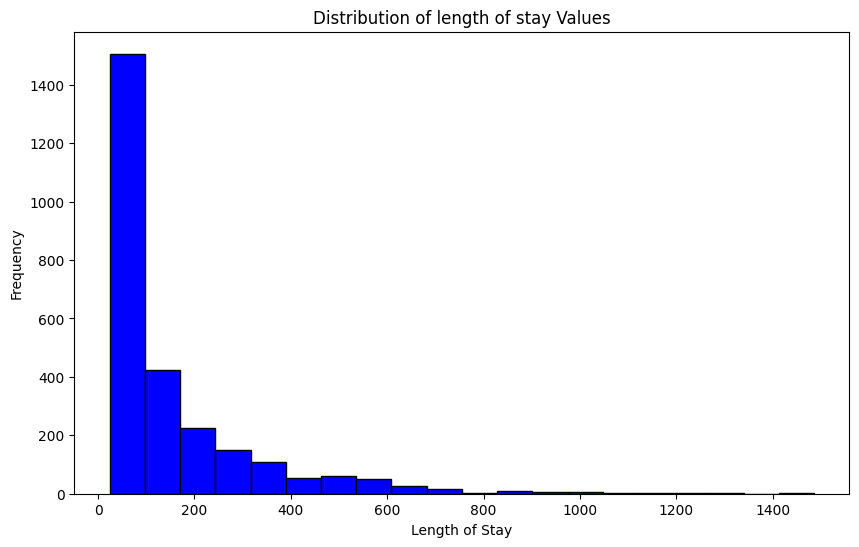

In [ ]:

los_hours_values = df['los_hours']

plt.figure(figsize=(10, 6))
plt.hist(los_hours_values, bins=20, color='blue', edgecolor='black')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.title('Distribution of length of stay Values')
plt.show()

### Generalizing Length of Stay

In [ ]:
from collections import deque
df['los_hours'] = df['los_hours'].astype(float)
class TreeNode:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.children = []

def build_tree(data, level, node):
    if level == 0 or len(data) < 10:
        return

    unique_data = np.unique(data)  # Get unique values before splitting
    median_idx = len(unique_data) // 2

    left_data = unique_data[:median_idx]
    right_data = unique_data[median_idx:]

    median = (left_data[-1] + right_data[0]) / 2

    left_child = TreeNode(node.start, median)
    right_child = TreeNode(median, node.end)

    node.children.append(left_child)
    node.children.append(right_child)

    build_tree(left_data, level - 1, left_child)
    build_tree(right_data, level - 1, right_child)



def print_tree(tree):
    queue = deque([(tree, 0)])  # Store nodes and their levels in a queue

    while queue:
        level_nodes = []  # Store nodes at the current level
        level = queue[0][1]  # Get the level of the first node in the queue

        # Process nodes at the current level
        while queue and queue[0][1] == level:
            node, _ = queue.popleft()
            level_nodes.append(node)

        # Print level name and clusters with intervals
        print(f"Level {level}:")
        for node in level_nodes:
            start = int(node.start)
            end = int(node.end)
            print(f"  Cluster {level_nodes.index(node)}: ({start}, {end}]")

        # Add child nodes to the queue for the next level
        for node in level_nodes:
            queue.extend([(child, level ) for child in node.children])

        print()  # Add a line break after each level


los_hours_column = df['los_hours']
min_los_hours = los_hours_column.min()
max_los_hours = los_hours_column.max()

# Build the tree with 5 levels
#original
root = TreeNode(min_los_hours, max_los_hours+1)
#adjusted
#root = TreeNode(min_age, max_age + 1)
build_tree(los_hours_column, 5, root)


print_tree(root)


Level 0:
  Cluster 0: (24, 1487]

Level 0:
  Cluster 0: (24, 89]
  Cluster 1: (89, 1487]

Level 0:
  Cluster 0: (24, 47]
  Cluster 1: (47, 89]
  Cluster 2: (89, 201]
  Cluster 3: (201, 1487]

Level 0:
  Cluster 0: (24, 34]
  Cluster 1: (34, 47]
  Cluster 2: (47, 64]
  Cluster 3: (64, 89]
  Cluster 4: (89, 132]
  Cluster 5: (132, 201]
  Cluster 6: (201, 339]
  Cluster 7: (339, 1487]

Level 0:
  Cluster 0: (24, 28]
  Cluster 1: (28, 34]
  Cluster 2: (34, 42]
  Cluster 3: (42, 47]
  Cluster 4: (47, 52]
  Cluster 5: (52, 64]
  Cluster 6: (64, 72]
  Cluster 7: (72, 89]
  Cluster 8: (89, 105]
  Cluster 9: (105, 132]
  Cluster 10: (132, 163]
  Cluster 11: (163, 201]
  Cluster 12: (201, 260]
  Cluster 13: (260, 339]
  Cluster 14: (339, 497]
  Cluster 15: (497, 1487]

Level 0:
  Cluster 0: (24, 25]
  Cluster 1: (25, 28]
  Cluster 2: (28, 30]
  Cluster 3: (30, 34]
  Cluster 4: (34, 38]
  Cluster 5: (38, 42]
  Cluster 6: (42, 44]
  Cluster 7: (44, 47]
  Cluster 8: (47, 49]
  Cluster 9: (49, 52]
 

In [ ]:
import math


# Convert the 'los_hours_column' to a numeric data type, handling non-numeric values with 'coerce'
los_hours_column = pd.to_numeric(df['los_hours'], errors='coerce')

# After this conversion, the 'los_hours_column' should contain numeric data, and the error should be resolved.
min_los_hours = los_hours_column.min()
max_los_hours = los_hours_column.max()

class TreeNode:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.children = []

def build_tree(data, level, node):
    if level == 0 or len(data) < 10:
        return

    unique_data = np.unique(data)  # Get unique values before splitting
    median_idx = len(unique_data) // 2

    left_data = unique_data[:median_idx]
    right_data = unique_data[median_idx:]

    median = (left_data[-1] + right_data[0]) / 2

    left_child = TreeNode(node.start, median)
    right_child = TreeNode(median, node.end)

    node.children.append(left_child)
    node.children.append(right_child)

    build_tree(left_data, level - 1, left_child)
    build_tree(right_data, level - 1, right_child)

# Build the tree with 5 levels
root = TreeNode(min_los_hours, max_los_hours)
build_tree(los_hours_column, 5, root)

# Convert the tree structure to a dictionary of los_hours clusters by level
los_hours_clusters_by_level = {}
def traverse_tree(node, level, clusters):
    if level not in clusters:
        clusters[level] = []
    clusters[level].append([(node.start, node.end)])
    for child in node.children:
        traverse_tree(child, level + 1, clusters)

traverse_tree(root, 1, los_hours_clusters_by_level)

# Create the los_hours level and cluster mappings
los_hours_mapping = {}
for level, clusters in los_hours_clusters_by_level.items():
    level_name = f'L{level}_los_hours'
    los_hours_mapping[level_name] = clusters

# Add new los_hours level columns to the DataFrame with non-overlapping intervals
for level, clusters in los_hours_mapping.items():
    df[level] = None  # Initialize the new column with None values

    current_end = min_los_hours  # Initialize the current end point

    for cluster_index, cluster in enumerate(clusters):
        start, end = cluster[0]

        # Ensure intervals are non-overlapping
        start = max(current_end, math.floor(start))
        end = math.ceil(end)

        # Calculate the interval end differently for the last cluster
        if cluster_index == len(clusters) - 1:
            end = max_los_hours + 1  # Extend to one unit beyond the max los_hours
        else:
            end = math.ceil(end)  # Round up to the nearest whole number

        interval = f'[{start}, {end})'
        mask = (los_hours_column >= start) & (los_hours_column < end)

        df.loc[mask, level] = interval
        current_end = end

In [ ]:
highest_value = df['los_hours'].max()
least_value = df['los_hours'].min()

print("Highest value in los_hours column:", highest_value)
print("Least value in los_hours column:", least_value)


Highest value in los_hours column: 1486.0
Least value in los_hours column: 24.06


In [ ]:
categorical_columns = ['L1_age', 'L1_los_hours', 'L2_los_hours',
       'L3_los_hours', 'L4_los_hours', 'L5_los_hours', 'L6_los_hours']


for column in categorical_columns:
    unique_values = df[column].unique()
    frequencies = df[column].value_counts()
    print(f"Unique values in {column}: {unique_values}")
    print(f"Frequencies:\n{frequencies}\n")

Unique values in L1_age: ['[18, 92.0)']
Frequencies:
[18, 92.0)    2655
Name: L1_age, dtype: int64

Unique values in L1_los_hours: ['[24.06, 1487.0)']
Frequencies:
[24.06, 1487.0)    2655
Name: L1_los_hours, dtype: int64

Unique values in L2_los_hours: ['[24.06, 90)' '[90, 1487.0)']
Frequencies:
[24.06, 90)     1413
[90, 1487.0)    1242
Name: L2_los_hours, dtype: int64

Unique values in L3_los_hours: ['[48, 90)' '[202, 1487.0)' '[90, 202)' '[24.06, 48)']
Frequencies:
[24.06, 48)      750
[48, 90)         663
[90, 202)        627
[202, 1487.0)    615
Name: L3_los_hours, dtype: int64

Unique values in L4_los_hours: ['[65, 90)' '[202, 340)' '[133, 202)' '[340, 1487.0)' '[24.06, 35)'
 '[90, 133)' '[48, 65)' '[35, 48)']
Frequencies:
[35, 48)         377
[24.06, 35)      373
[48, 65)         337
[65, 90)         326
[90, 133)        317
[133, 202)       310
[202, 340)       309
[340, 1487.0)    306
Name: L4_los_hours, dtype: int64

Unique values in L5_los_hours: ['[73, 90)' '[261, 340)' '[13

In [ ]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
age,82.0,67.0,69.0,57.0,37.0,55.0,58.0,87.0,69.0,24.0
weight,NaN,74.0,NaN,NaN,131.8,122.9,NaN,78.0,101.0,NaN
gender,0,1,0,0,1,1,1,0,0,1
ethnicity,1,1,1,1,0,1,4,1,1,4
marital_status,NaN,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0
infarct_type,no_infarct,no_infarct,no_infarct,no_infarct,no_infarct,NSTEMI,no_infarct,no_infarct,no_infarct,no_infarct
hypertension_flag,1,1,1,1,1,1,1,1,1,0
diabetes_flag,0,1,1,0,0,0,0,0,1,0
cancer_flag,0,1,0,0,0,0,0,0,0,0
obesity_flag,0,0,0,0,1,0,0,0,0,0


-----------------------------

In [ ]:
'''
from collections import deque
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

class TreeNode:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.children = []

def build_tree(data, level, min_val, max_val):
    root = TreeNode(min_val, max_val)
    build_subtree(data, level, root)
    return root

def build_subtree(data, level, node):
    if level == 0 or len(data) <= 10:  # Terminate if level is 0 or fewer than 10 samples in the node
        return

    # Reshape the data for K-means clustering
    X = data.values.reshape(-1, 1)

    # Perform K-means++ clustering with 2 clusters
    kmeans = KMeans(n_clusters=2, init='k-means++')
    kmeans.fit(X)

    # Get the cluster centers
    centers = kmeans.cluster_centers_.squeeze()
    centers.sort()

    left_child = TreeNode(node.start, centers[0])
    right_child = TreeNode(centers[0], node.end)

    node.children.append(left_child)
    node.children.append(right_child)

    left_data = data[data < centers[0]]  # Adjust interval boundaries to avoid duplicates
    if len(left_data) > 10:
        build_subtree(left_data, level - 1, left_child)

    right_data = data[data >= centers[0]]  # Adjust interval boundaries to avoid duplicates
    if len(right_data) > 10:
        build_subtree(right_data, level - 1, right_child)

def print_tree(tree):
    queue = deque([(tree, 0)])  # Store nodes and their levels in a queue

    while queue:
        level_nodes = []  # Store nodes at the current level
        level = queue[0][1]  # Get the level of the first node in the queue

        # Process nodes at the current level
        while queue and queue[0][1] == level:
            node, _ = queue.popleft()
            level_nodes.append(node)

        # Print level name and clusters with intervals
        print(f"Level {level}:")
        for node in level_nodes:
            start = int(node.start) if node.start.is_integer() else round(node.start)
            end = int(node.end) if node.end.is_integer() else round(node.end)
            print(f"  Cluster {level_nodes.index(node)}: ({start}, {end}]")

        # Add child nodes to the queue for the next level
        for node in level_nodes:
            queue.extend([(child, level + 1) for child in node.children])

        print()  # Add a line break after each level

los_hours_column = df['los_hours']
min_los_hours = los_hours_column.min()
max_los_hours = los_hours_column.max()

# Build the tree with 5 levels
tree = build_tree(los_hours_column, 4, min_los_hours, max_los_hours)

# Print the tree
print_tree(tree)
'''


'\nfrom collections import deque\nfrom sklearn.cluster import KMeans\nimport warnings\nwarnings.filterwarnings("ignore")\n\nclass TreeNode:\n    def __init__(self, start, end):\n        self.start = start\n        self.end = end\n        self.children = []\n\ndef build_tree(data, level, min_val, max_val):\n    root = TreeNode(min_val, max_val)\n    build_subtree(data, level, root)\n    return root\n\ndef build_subtree(data, level, node):\n    if level == 0 or len(data) <= 10:  # Terminate if level is 0 or fewer than 10 samples in the node\n        return\n\n    # Reshape the data for K-means clustering\n    X = data.values.reshape(-1, 1)\n\n    # Perform K-means++ clustering with 2 clusters\n    kmeans = KMeans(n_clusters=2, init=\'k-means++\')\n    kmeans.fit(X)\n\n    # Get the cluster centers\n    centers = kmeans.cluster_centers_.squeeze()\n    centers.sort()\n\n    left_child = TreeNode(node.start, centers[0])\n    right_child = TreeNode(centers[0], node.end)\n\n    node.children.

In [ ]:
'''
# Assuming now that df is the DataFrame containing the los_hours column
los_hours_column = df['los_hours']
min_los_hourse = los_hours_column.min()
max_los_hours = los_hours_column.max()

# Build the tree with 5 levels
root = build_tree(los_hours_column, 5, min_los_hours, max_los_hours)


# Convert the tree structure to a dictionary of los_hours clusters by level
los_hours_clusters_by_level = {}
def traverse_tree(node, level, clusters):
    if level not in clusters:
        clusters[level] = []
    clusters[level].append([(node.start, node.end)])
    for child in node.children:
        traverse_tree(child, level + 1, clusters)

traverse_tree(root, 1, los_hours_clusters_by_level)

# Create the los_hours level and cluster mappings
los_hours_mapping = {}
for level, clusters in los_hours_clusters_by_level.items():
    level_name = f'Level_{level}_los_hours'
    los_hours_mapping[level_name] = clusters

# Print the los_hours level and cluster mappings
for level, clusters in los_hours_mapping.items():
    print(f"{level}:")
    for cluster_index, cluster in enumerate(clusters):
        print(f"  Cluster {cluster_index + 1}: [{cluster[0][0]}, {cluster[0][1]})")
    print()


# Add new los_hours level columns to the DataFrame
for level, clusters in los_hours_mapping.items():
    df[level] = None  # Initialize the new column with None values

    for cluster_index, cluster in enumerate(clusters):
        start, end = cluster[0]
        interval = f'[{start}, {end})'
        mask = (los_hours_column >= start) & (los_hours_column < end)
        df.loc[mask, level] = interval

# Add new age level columns to the DataFrame
for level, clusters in los_hours_mapping.items():
    df[level] = None  # Initialize the new column with None values

    for cluster_index, cluster in enumerate(clusters):
        start, end = cluster[0]

        # Calculate the interval end differently for the last cluster
        if cluster_index == len(clusters) - 1:
            end = max_los_hours + 1  # Extend to one unit beyond the max age

        interval = f'[{start}, {end})'
        mask = (los_hours_column >= start) & (los_hours_column < end)

        df.loc[mask, level] = interval
        '''

'\n# Assuming now that df is the DataFrame containing the los_hours column\nlos_hours_column = df[\'los_hours\']\nmin_los_hourse = los_hours_column.min()\nmax_los_hours = los_hours_column.max()\n\n# Build the tree with 5 levels\nroot = build_tree(los_hours_column, 5, min_los_hours, max_los_hours)\n\n\n# Convert the tree structure to a dictionary of los_hours clusters by level\nlos_hours_clusters_by_level = {}\ndef traverse_tree(node, level, clusters):\n    if level not in clusters:\n        clusters[level] = []\n    clusters[level].append([(node.start, node.end)])\n    for child in node.children:\n        traverse_tree(child, level + 1, clusters)\n\ntraverse_tree(root, 1, los_hours_clusters_by_level)\n\n# Create the los_hours level and cluster mappings\nlos_hours_mapping = {}\nfor level, clusters in los_hours_clusters_by_level.items():\n    level_name = f\'Level_{level}_los_hours\'\n    los_hours_mapping[level_name] = clusters\n\n# Print the los_hours level and cluster mappings\nfor le

### Generalizing or Mapping Admission type, Marital Status, Stroke type and Ethnicity

In [ ]:
# Create a mapping dictionary
mapping_admission_type = {0: 'Elective', 1: 'Emergency', 2: 'Urgent'}
mapping_marital_status = {0: 'Unknown', 1: 'Life partner present', -1: 'No life partner'}
mapping_stroke_type = {1: 'Ischemic', 2: 'Other stroke', 3: 'Hemorrhagic'}
mapping_ethnicity = {0: 'Unknown', 1: 'White', 2: 'Asian', 3:'Latino', 4:'Black', 5:'Other'}




# Map the integer categories to string labels
df['admission_type'] = df['admission_type'].map(mapping_admission_type)
df['marital_status'] = df['marital_status'].map(mapping_marital_status)
df['stroke_type'] = df['stroke_type'].map(mapping_stroke_type)
df['ethnicity'] = df['ethnicity'].map(mapping_ethnicity)



admission_type_mapping = {
    'L1_Admission_Type': {
        "Elective": ["Elective/Urgent"],
        "Emergency": ["Emergency"],
        "Urgent": ["Elective/Urgent"],
    }
}
'''
ethnicity_mapping = {
    'L2_Ethnicity': { #3 distinc values
        "Unknown": ["Unknown/Other"],
        "White": ["White/Asian"],
        "Asian": ["White/Asian"],
        "Latino": ["Latino/Black"],
        "Black": ["Latino/Black"],
        "Other": ["Unknown/Other"]
    },
    'L1_Ethnicity': { #3 distinc values more gen than 1.1
        "Unknown": ["Unknown"],
        "White": ["White"],
        "Asian": ["Non-White"],
        "Latino": ["Non-White"],
        "Black": ["Non-White"],
        "Other": ["Non-White"]
    },
    'L3_Ethnicity': { #4 distinc values
        "Unknown": ["Unknown"],
        "White": ["White"],
        "Asian": ["Non-White"],
        "Latino": ["Non-White"],
        "Black": ["Black"],
        "Other": ["Non-White"]
    }
}
'''


ethnicity_mapping = {
    'L1_Ethnicity': { #3 distinc values more gen than 1.1
        "Unknown": ["Unknown"],
        "White": ["White/Asian"],
        "Asian": ["White/Asian"],
        "Latino": ["Non-White"],
        "Black": ["Non-White"],
        "Other": ["Non-White"]
    },
    'L2_Ethnicity': { #4 distinc values
        "Unknown": ["Unknown"],
        "White": ["White/Asian"],
        "Asian": ["White/Asian"],
        "Latino": ["Latino/Black"],
        "Black": ["Latino/Black"],
        "Other": ["Other"]
    }
}



for col, mapping in admission_type_mapping.items():
    df[col] = df['admission_type'].map({key: ' '.join(value) for key, value in mapping.items()})

for col, mapping in ethnicity_mapping.items():
    df[col] = df['ethnicity'].map({key: ' '.join(value) for key, value in mapping.items()})

df.rename(columns={'ethnicity': 'L3_Ethnicity'}, inplace=True)
df.rename(columns={'admission_type': 'L2_Admission_Type'}, inplace=True)

In [ ]:
'''
# Define a function to combine the columns
def combine_diseases(row):
    diseases = []
    if row['diabetes_flag'] == 1:
        diseases.append('Diabetes')
    if row['cancer_flag'] == 1:
        diseases.append('Cancer')
    if row['hypertension_flag'] == 1:
        diseases.append('Hypertension')
    if row['obesity_flag'] == 1:
        diseases.append('Obesity')
    if row['drug_abuse_flag'] == 1:
        diseases.append('Drug Abuse')

    return ', '.join(diseases) if diseases else 'None'

# Apply the function to create the new column
df['diseases'] = df.apply(combine_diseases, axis=1)

# Define a function to generalize disease combinations
def generalize_disease_combination(disease_combination):
    if "Diabetes" in disease_combination or "Obseity" in disease_combination:
        return "Metabolical Disorder"
    if "Hypertension" in disease_combination:
        return "Cardiovascular Disorder"
    if "Cancer" in disease_combination:
        return "Oncological Disorder"
    if "Drug Abuse" in disease_combination:
        return "Behavioral Disorder"
    return "None"

# Create the L1_Diseases column using the generalization function
df['L2_Diseases'] = df['diseases'].apply(generalize_disease_combination)

# Create the L2_Diseases column using the L1_Diseases column
df['L1_Diseases'] = df['L2_Diseases'].replace({
    "Cardiovascular Disorder": "Chronic Disorders",
    "Metabolical Disorder": "Chronic Disorders",
    "Oncological Disorder": "Chronic Disorders",
    "Behavioral Disorder": "Non-Chronic Disorders",
    "None": "Non-Chronic Disorders"
})
df.rename(columns={'diseases': 'L3_Diseases'}, inplace=True)
'''

'\n# Define a function to combine the columns\ndef combine_diseases(row):\n    diseases = []\n    if row[\'diabetes_flag\'] == 1:\n        diseases.append(\'Diabetes\')\n    if row[\'cancer_flag\'] == 1:\n        diseases.append(\'Cancer\')\n    if row[\'hypertension_flag\'] == 1:\n        diseases.append(\'Hypertension\')\n    if row[\'obesity_flag\'] == 1:\n        diseases.append(\'Obesity\')\n    if row[\'drug_abuse_flag\'] == 1:\n        diseases.append(\'Drug Abuse\')\n\n    return \', \'.join(diseases) if diseases else \'None\'\n\n# Apply the function to create the new column\ndf[\'diseases\'] = df.apply(combine_diseases, axis=1)\n\n# Define a function to generalize disease combinations\ndef generalize_disease_combination(disease_combination):\n    if "Diabetes" in disease_combination or "Obseity" in disease_combination:\n        return "Metabolical Disorder"\n    if "Hypertension" in disease_combination:\n        return "Cardiovascular Disorder"\n    if "Cancer" in disease_comb

In [ ]:
# Define a function to combine the columns
def combine_diseases(row):
    diseases = []
    if row['diabetes_flag'] == 1:
        diseases.append('Diabetes')
    if row['cancer_flag'] == 1:
        diseases.append('Cancer')
    if row['hypertension_flag'] == 1:
        diseases.append('Hypertension')
    if row['obesity_flag'] == 1:
        diseases.append('Obesity')
    if row['drug_abuse_flag'] == 1:
        diseases.append('Drug Abuse')

    return ', '.join(diseases) if diseases else 'None'

# Apply the function to create the new column
df['L2_Diseases'] = df.apply(combine_diseases, axis=1)



def combine_diseases(row):
    diseases = []

    if row['diabetes_flag'] == 1 or row['cancer_flag'] == 1 or row['hypertension_flag'] == 1:
        diseases.append('Chronic Disorder')

    if row['obesity_flag'] == 1 or row['drug_abuse_flag'] == 1:
        diseases.append('Non-chronic Disorder')

    if row['diabetes_flag'] == 1 or row['cancer_flag'] == 1 or row['hypertension_flag'] == 1:
        if row['obesity_flag'] == 1 or row['drug_abuse_flag'] == 1:
            diseases = ['Both']

    if not diseases:
        diseases.append('None')

    return ', '.join(diseases)

# Apply the function to create the new column
df['diseases'] = df.apply(combine_diseases, axis=1)


# Apply the function to create the new column
df['L1_Diseases'] = df.apply(combine_diseases, axis=1)


#df.rename(columns={'diseases': 'L2_Diseases'}, inplace=True)

In [ ]:
categorical_columns = ['L1_Diseases', 'L2_Diseases']


for column in categorical_columns:
    unique_values = df[column].unique()
    frequencies = df[column].value_counts()
    print(f"Unique values in {column}: {unique_values}")
    print(f"Frequencies:\n{frequencies}\n")

Unique values in L1_Diseases: ['Chronic Disorder' 'Both' 'Non-chronic Disorder' 'None']
Frequencies:
Chronic Disorder        1622
None                     628
Both                     271
Non-chronic Disorder     134
Name: L1_Diseases, dtype: int64

Unique values in L2_Diseases: ['Hypertension' 'Diabetes, Cancer, Hypertension' 'Diabetes, Hypertension'
 'Hypertension, Obesity' 'Drug Abuse' 'None'
 'Cancer, Hypertension, Drug Abuse' 'Cancer' 'Diabetes'
 'Diabetes, Hypertension, Obesity, Drug Abuse' 'Cancer, Hypertension'
 'Hypertension, Drug Abuse' 'Diabetes, Hypertension, Obesity'
 'Diabetes, Drug Abuse' 'Cancer, Drug Abuse'
 'Diabetes, Hypertension, Drug Abuse' 'Diabetes, Obesity'
 'Diabetes, Cancer' 'Cancer, Hypertension, Obesity' 'Obesity'
 'Hypertension, Obesity, Drug Abuse' 'Diabetes, Obesity, Drug Abuse'
 'Diabetes, Cancer, Drug Abuse' 'Diabetes, Cancer, Hypertension, Obesity'
 'Diabetes, Cancer, Hypertension, Drug Abuse' 'Cancer, Obesity'
 'Obesity, Drug Abuse' 'Diabetes, Cancer,

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 58 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2655 non-null   float64
 1   weight             1309 non-null   float64
 2   gender             2655 non-null   int64  
 3   L3_Ethnicity       2655 non-null   object 
 4   marital_status     2442 non-null   object 
 5   infarct_type       2655 non-null   object 
 6   hypertension_flag  2655 non-null   int64  
 7   diabetes_flag      2655 non-null   int64  
 8   cancer_flag        2655 non-null   int64  
 9   obesity_flag       2655 non-null   int64  
 10  drug_abuse_flag    2655 non-null   int64  
 11  anion_gap          2499 non-null   float64
 12  abp_diastolic      2072 non-null   float64
 13  abp_systolic       2073 non-null   float64
 14  bicarbonate        2500 non-null   float64
 15  calcium            1087 non-null   float64
 16  chloride           2570 

In [ ]:
df.columns

Index(['age', 'weight', 'gender', 'L3_Ethnicity', 'marital_status',
       'infarct_type', 'hypertension_flag', 'diabetes_flag', 'cancer_flag',
       'obesity_flag', 'drug_abuse_flag', 'anion_gap', 'abp_diastolic',
       'abp_systolic', 'bicarbonate', 'calcium', 'chloride', 'creatinine',
       'all_icd9_codes', 'gauges_total', 'gcs', 'glucose', 'heart_rate',
       'hemoglobin', 'inr', 'o2_saturation', 'oasis', 'packed_rbc',
       'los_hours', 'platelet_count', 'potassium', 'repiratory_rate', 'sodium',
       'wbc', 'stroke_type', 'icustays_count', 'L2_Admission_Type',
       'death_in_hosp', 'religion', 'death_365_days', 'L1_age', 'L2_age',
       'L3_age', 'L4_age', 'L5_age', 'L6_age', 'L1_los_hours', 'L2_los_hours',
       'L3_los_hours', 'L4_los_hours', 'L5_los_hours', 'L6_los_hours',
       'L1_Admission_Type', 'L1_Ethnicity', 'L2_Ethnicity', 'L2_Diseases',
       'diseases', 'L1_Diseases'],
      dtype='object')

###ToDo: Impute and Fix class imbalance  (or keep it for the classification model ??)

Marital Status: Hot deck

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 58 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2655 non-null   float64
 1   weight             1309 non-null   float64
 2   gender             2655 non-null   int64  
 3   L3_Ethnicity       2655 non-null   object 
 4   marital_status     2442 non-null   object 
 5   infarct_type       2655 non-null   object 
 6   hypertension_flag  2655 non-null   int64  
 7   diabetes_flag      2655 non-null   int64  
 8   cancer_flag        2655 non-null   int64  
 9   obesity_flag       2655 non-null   int64  
 10  drug_abuse_flag    2655 non-null   int64  
 11  anion_gap          2499 non-null   float64
 12  abp_diastolic      2072 non-null   float64
 13  abp_systolic       2073 non-null   float64
 14  bicarbonate        2500 non-null   float64
 15  calcium            1087 non-null   float64
 16  chloride           2570 

In [ ]:
# Iterate through the rows with missing values in 'anion_gap' and 'abp_systolic'
for index, row in df[df['marital_status'].isnull()].iterrows():
    # Define a similarity measure (e.g., based on age, gender and other relevant attributes)
    # Find the most similar record(s) in the dataset
    similar_records = df[
        (df['age'] == row['age']) &  # Example: Matching based on age
        (df['gender'] == row['gender']) & # Example: Matching based on gender
        (df['L3_Ethnicity'] == row['L3_Ethnicity']) &
        (df['hypertension_flag'] == row['hypertension_flag']) &
        (df['diabetes_flag'] == row['diabetes_flag'])
    ]

    # Select a donor record
    donor_record = similar_records.sample(n=1)  # Example: Randomly select a similar record

    # Impute missing values based on the donor record
    if np.isnan(row['marital_status']):
        df.at[index, 'marital_status'] = donor_record['marital_status'].values[0]


In [ ]:
# Iterate through the rows with missing values in 'anion_gap' and 'abp_systolic'
for index, row in df[df['oasis'].isnull()].iterrows():
    # Define a similarity measure (e.g., based on age, gender and other relevant attributes)
    # Find the most similar record(s) in the dataset
    similar_records = df[
        (df['age'] == row['age']) &  # Example: Matching based on age
        (df['gender'] == row['gender']) & # Example: Matching based on gender
        (df['L3_Ethnicity'] == row['L3_Ethnicity']) &
        (df['hypertension_flag'] == row['hypertension_flag']) &
        (df['diabetes_flag'] == row['diabetes_flag'])
    ]

    # Select a donor record
    donor_record = similar_records.sample(n=1)  # Example: Randomly select a similar record

    # Impute missing values based on the donor record
    if np.isnan(row['oasis']):
        df.at[index, 'oasis'] = donor_record['oasis'].values[0]

In [ ]:
# Iterate through the rows with missing values in 'anion_gap' and 'abp_systolic'
for index, row in df[df['heart_rate'].isnull()].iterrows():
    # Define a similarity measure (e.g., based on age, gender and other relevant attributes)
    # Find the most similar record(s) in the dataset
    similar_records = df[
        (df['age'] == row['age']) &  # Example: Matching based on age
        (df['gender'] == row['gender']) & # Example: Matching based on gender
        (df['L3_Ethnicity'] == row['L3_Ethnicity']) &
        (df['hypertension_flag'] == row['hypertension_flag']) &
        (df['diabetes_flag'] == row['diabetes_flag'])
    ]

    # Select a donor record
    donor_record = similar_records.sample(n=1)  # Example: Randomly select a similar record

    # Impute missing values based on the donor record
    if np.isnan(row['heart_rate']):
        df.at[index, 'heart_rate'] = donor_record['heart_rate'].values[0]

In [ ]:
# Iterate through the rows with missing values in 'anion_gap' and 'abp_systolic'
for index, row in df[df['hemoglobin'].isnull()].iterrows():
    # Define a similarity measure (e.g., based on age, gender and other relevant attributes)
    # Find the most similar record(s) in the dataset
    similar_records = df[
        (df['age'] == row['age']) &  # Example: Matching based on age
        (df['gender'] == row['gender']) & # Example: Matching based on gender
        (df['L3_Ethnicity'] == row['L3_Ethnicity']) &
        (df['hypertension_flag'] == row['hypertension_flag']) &
        (df['diabetes_flag'] == row['diabetes_flag'])
    ]

    # Select a donor record
    donor_record = similar_records.sample(n=1)  # Example: Randomly select a similar record

    # Impute missing values based on the donor record
    if np.isnan(row['hemoglobin']):
        df.at[index, 'hemoglobin'] = donor_record['hemoglobin'].values[0]

In [ ]:
# Iterate through the rows with missing values in 'anion_gap' and 'abp_systolic'
for index, row in df[df['creatinine'].isnull()].iterrows():
    # Define a similarity measure (e.g., based on age, gender and other relevant attributes)
    # Find the most similar record(s) in the dataset
    similar_records = df[
        (df['age'] == row['age']) &  # Example: Matching based on age
        (df['gender'] == row['gender']) & # Example: Matching based on gender
        (df['L3_Ethnicity'] == row['L3_Ethnicity']) &
        (df['hypertension_flag'] == row['hypertension_flag']) &
        (df['diabetes_flag'] == row['diabetes_flag'])
    ]

    # Select a donor record
    donor_record = similar_records.sample(n=1)  # Example: Randomly select a similar record

    # Impute missing values based on the donor record
    if np.isnan(row['creatinine']):
        df.at[index, 'creatinine'] = donor_record['creatinine'].values[0]

In [ ]:
from sklearn.impute import SimpleImputer


# List of columns you want to impute
columns_to_impute = ['marital_status']

# Create a SimpleImputer instance with the desired strategy (mean, median, most_frequent, etc.)
imputer = SimpleImputer(strategy='most_frequent')  # You can change 'mean' to another strategy if needed

# Fit the imputer on the non-missing values of the selected columns
imputer.fit(df[columns_to_impute])

# Perform the imputation and replace missing values in the original DataFrame
df[columns_to_impute] = imputer.transform(df[columns_to_impute])

Mean imputation

In [ ]:
from sklearn.impute import SimpleImputer


# List of columns you want to impute
columns_to_impute = ['oasis', 'heart_rate', 'hemoglobin', 'creatinine']

# Create a SimpleImputer instance with the desired strategy (mean, median, most_frequent, etc.)
imputer = SimpleImputer(strategy='mean')  # You can change 'mean' to another strategy if needed

# Fit the imputer on the non-missing values of the selected columns
imputer.fit(df[columns_to_impute])

# Perform the imputation and replace missing values in the original DataFrame
df[columns_to_impute] = imputer.transform(df[columns_to_impute])

In [ ]:
'''
# Calculate the median of the 'anion_gap' attribute
median_anion_gap = df['oasis'].median()
# Impute missing values
df['anion_gap'].fillna(median_anion_gap, inplace=True)
'''

"\n# Calculate the median of the 'anion_gap' attribute\nmedian_anion_gap = df['oasis'].median()\n# Impute missing values\ndf['anion_gap'].fillna(median_anion_gap, inplace=True)\n"

RandomForestRegressor

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 58 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2655 non-null   float64
 1   weight             1309 non-null   float64
 2   gender             2655 non-null   int64  
 3   L3_Ethnicity       2655 non-null   object 
 4   marital_status     2655 non-null   object 
 5   infarct_type       2655 non-null   object 
 6   hypertension_flag  2655 non-null   int64  
 7   diabetes_flag      2655 non-null   int64  
 8   cancer_flag        2655 non-null   int64  
 9   obesity_flag       2655 non-null   int64  
 10  drug_abuse_flag    2655 non-null   int64  
 11  anion_gap          2499 non-null   float64
 12  abp_diastolic      2072 non-null   float64
 13  abp_systolic       2073 non-null   float64
 14  bicarbonate        2500 non-null   float64
 15  calcium            1087 non-null   float64
 16  chloride           2570 

Perfecto

In [ ]:
from sklearn.ensemble import RandomForestRegressor





# Define features and the target variables (attributes to impute)
features = ['age', 'heart_rate', 'gender', 'oasis', 'hemoglobin']

# Define the target attributes to impute
target_attributes = ['glucose', 'potassium', 'sodium', 'chloride', 'anion_gap']

# Create your Random Forest Regressor model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Iterate through each target attribute for imputation
for target_attribute in target_attributes:
    # Split your dataset into two subsets - one with missing values and one without for the current attribute
    df_missing = df[df[target_attribute].isnull()]
    df_not_missing = df[~df[target_attribute].isnull()]

    # Check if there are any missing values to impute
    if not df_missing.empty:
        # Separate the feature columns and the target column for regression
        X_train = df_not_missing[features]
        y_train = df_not_missing[target_attribute]

        # Fit the Random Forest Regressor model
        random_forest.fit(X_train, y_train)

        # Impute the missing values for the current attribute using the trained Random Forest Regressor model
        X_test = df_missing[features]
        imputed_values = random_forest.predict(X_test)

        # Update the original dataset with the imputed values
        df.loc[df[target_attribute].isnull(), target_attribute] = imputed_values

In [ ]:
# Define features and the target variables (attributes to impute)
features = ['age', 'heart_rate', 'gender', 'oasis', 'hemoglobin', 'glucose', 'potassium', 'sodium', 'chloride', 'anion_gap', 'creatinine']

# Define the target attributes to impute
target_attributes = ['calcium', 'abp_systolic', 'abp_diastolic']

# Create your Random Forest Regressor model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Iterate through each target attribute for imputation
for target_attribute in target_attributes:
    # Split your dataset into two subsets - one with missing values and one without for the current attribute
    df_missing = df[df[target_attribute].isnull()]
    df_not_missing = df[~df[target_attribute].isnull()]

    # Check if there are any missing values to impute
    if not df_missing.empty:
        # Separate the feature columns and the target column for regression
        X_train = df_not_missing[features]
        y_train = df_not_missing[target_attribute]

        # Fit the Random Forest Regressor model
        random_forest.fit(X_train, y_train)

        # Impute the missing values for the current attribute using the trained Random Forest Regressor model
        X_test = df_missing[features]
        imputed_values = random_forest.predict(X_test)

        # Update the original dataset with the imputed values
        df.loc[df[target_attribute].isnull(), target_attribute] = imputed_values

In [ ]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
age,82.0,67.0,69.0,57.0,37.0,55.0,58.0,87.0,69.0,24.0
weight,NaN,74.0,NaN,NaN,131.8,122.9,NaN,78.0,101.0,NaN
gender,0,1,0,0,1,1,1,0,0,1
L3_Ethnicity,White,White,White,White,Unknown,White,Black,White,White,Black
marital_status,No life partner,No life partner,No life partner,Life partner present,No life partner,No life partner,Life partner present,No life partner,Life partner present,Life partner present
infarct_type,no_infarct,no_infarct,no_infarct,no_infarct,no_infarct,NSTEMI,no_infarct,no_infarct,no_infarct,no_infarct
hypertension_flag,1,1,1,1,1,1,1,1,1,0
diabetes_flag,0,1,1,0,0,0,0,0,1,0
cancer_flag,0,1,0,0,0,0,0,0,0,0
obesity_flag,0,0,0,0,1,0,0,0,0,0


In [ ]:
if 'los_hours_interval' in df.columns:
    df.drop('los_hours_interval', axis=1, inplace=True)

In [ ]:
if 'L3_Diseasesas' in df.columns:
    df.drop('L3_Diseasesas', axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 58 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2655 non-null   float64
 1   weight             1309 non-null   float64
 2   gender             2655 non-null   int64  
 3   L3_Ethnicity       2655 non-null   object 
 4   marital_status     2655 non-null   object 
 5   infarct_type       2655 non-null   object 
 6   hypertension_flag  2655 non-null   int64  
 7   diabetes_flag      2655 non-null   int64  
 8   cancer_flag        2655 non-null   int64  
 9   obesity_flag       2655 non-null   int64  
 10  drug_abuse_flag    2655 non-null   int64  
 11  anion_gap          2655 non-null   float64
 12  abp_diastolic      2655 non-null   float64
 13  abp_systolic       2655 non-null   float64
 14  bicarbonate        2500 non-null   float64
 15  calcium            2655 non-null   float64
 16  chloride           2655 

ToDo: Check if it's okay to upload it on Github

In [ ]:
!pip install catboost

In [ ]:
df.columns

Index(['age', 'weight', 'gender', 'L3_Ethnicity', 'marital_status',
       'infarct_type', 'hypertension_flag', 'diabetes_flag', 'cancer_flag',
       'obesity_flag', 'drug_abuse_flag', 'anion_gap', 'abp_diastolic',
       'abp_systolic', 'bicarbonate', 'calcium', 'chloride', 'creatinine',
       'all_icd9_codes', 'gauges_total', 'gcs', 'glucose', 'heart_rate',
       'hemoglobin', 'inr', 'o2_saturation', 'oasis', 'packed_rbc',
       'los_hours', 'platelet_count', 'potassium', 'repiratory_rate', 'sodium',
       'wbc', 'stroke_type', 'icustays_count', 'L2_Admission_Type',
       'death_in_hosp', 'religion', 'death_365_days', 'L1_age', 'L2_age',
       'L3_age', 'L4_age', 'L5_age', 'L6_age', 'L1_los_hours', 'L2_los_hours',
       'L3_los_hours', 'L4_los_hours', 'L5_los_hours', 'L6_los_hours',
       'L1_Admission_Type', 'L1_Ethnicity', 'L2_Ethnicity', 'L2_Diseases',
       'diseases', 'L1_Diseases'],
      dtype='object')

In [ ]:
# Assuming df is your DataFrame and columns_to_drop is a list of column names to drop
columns_to_drop = ['weight', 'inr', 'gauges_total',  'packed_rbc', 'hypertension_flag', 'diabetes_flag', 'cancer_flag',
       'obesity_flag', 'drug_abuse_flag', 'o2_saturation', 'religion', 'icustays_count', 'all_icd9_codes', 'death_in_hosp']

df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2655 non-null   float64
 1   gender             2655 non-null   int64  
 2   L3_Ethnicity       2655 non-null   object 
 3   marital_status     2655 non-null   object 
 4   infarct_type       2655 non-null   object 
 5   anion_gap          2655 non-null   float64
 6   abp_diastolic      2655 non-null   float64
 7   abp_systolic       2655 non-null   float64
 8   bicarbonate        2500 non-null   float64
 9   calcium            2655 non-null   float64
 10  chloride           2655 non-null   float64
 11  creatinine         2655 non-null   float64
 12  gcs                2635 non-null   float64
 13  glucose            2655 non-null   float64
 14  heart_rate         2655 non-null   float64
 15  hemoglobin         2655 non-null   float64
 16  oasis              2655 

In [ ]:
df.rename(columns={'age': 'L7_age',
                   'los_hours': 'L7_los_hours'}, inplace=True)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report

#selected_columns = best_solution

# Additional columns to include in the feature set
# maybe add oasis and glucose later

'''
additional_columns = [ 'weight', 'infarct_type', 'hypertension_flag', 'diabetes_flag', 'cancer_flag',
       'obesity_flag', 'drug_abuse_flag', 'anion_gap', 'abp_diastolic',
       'abp_systolic', 'bicarbonate', 'calcium', 'chloride', 'creatinine',
       'gauges_total', 'gcs', 'glucose', 'heart_rate',
       'hemoglobin', 'o2_saturation', 'oasis', 'packed_rbc',
       'platelet_count', 'potassium', 'repiratory_rate', 'sodium',
       'wbc', 'death_365_days']
'''

features = ['age', 'gender', 'L3_Ethnicity', #'weight',
       'infarct_type', 'anion_gap', 'abp_diastolic', 'marital_status',
       'abp_systolic', 'bicarbonate', 'calcium', 'chloride', 'creatinine',
        'gcs', 'glucose', 'heart_rate',
       'hemoglobin',  'oasis',
       'los_hours', 'platelet_count', 'potassium', 'repiratory_rate', 'sodium',
       'wbc', 'stroke_type', 'L2_Admission_Type', 'L2_Diseases',
       'death_365_days']


featurez_matrix = df[features]
# Set a random seed for reproducibility
random_seed = 23  # You can use any integer value as the seed
np.random.seed(random_seed)

# Prepare the feature matrix (X) and target variable (y)
X = featurez_matrix.drop('death_365_days', axis=1)
y = featurez_matrix['death_365_days']


# Convert categorical features to strings
categorical_features_indices = X.select_dtypes(include=['object']).columns
#X[categorical_features_indices] = X[categorical_features_indices].astype(str)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)



# Initialize the CatBoostClassifier #depth 11, iterations 600 le .04 ergab auc 0.793
catboost_model = CatBoostClassifier(iterations=350, depth=9, learning_rate=0.04, loss_function='Logloss', cat_features=list(categorical_features_indices))

# Train the model on the training data
catboost_model.fit(X_train, y_train, cat_features=list(categorical_features_indices))  # Convert to list here

# Predict on the testing data
y_pred = catboost_model.predict(X_test)
# Convert the predicted labels to string type
#y_pred = y_pred.astype(str)




# Evaluate the model's performance
classification_metrics = classification_report(y_test, y_pred)
print(classification_metrics)

# Calculate AUC-ROC score

auc_roc = roc_auc_score(y_test.astype(int), y_pred.astype(int))
print("AUC-ROC Score:", auc_roc)



KeyError: "['age', 'los_hours'] not in index"

In [ ]:
# Save the pre-processed dataset on drive
df.to_csv('/content/drive/MyDrive/Colab Notebooks/MIMIC III/preprocessed/pre-processed-MIMICIII-SA(arx_gen).csv', index=False)


In [ ]:
df.info()